In [2]:
# ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# System related and data input controls
import os

# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

# Modeling algorithms
# General
import statsmodels.api as sm
from scipy import stats

# Model selection
from sklearn.model_selection import train_test_split

# Evaluation metrics
from sklearn import metrics

# for regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [3]:
# Load Boston Data and Check Data
df = pd.read_csv("Data/Price.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Price    506 non-null    float64
 1   CRIM     495 non-null    float64
 2   ZN       506 non-null    object 
 3   INDUS    473 non-null    float64
 4   CHAS     506 non-null    object 
 5   NOX      506 non-null    float64
 6   RM       504 non-null    float64
 7   AGE      506 non-null    float64
 8   DIS      449 non-null    float64
 9   RAD      506 non-null    int64  
 10  TAX      506 non-null    int64  
 11  PTRATIO  506 non-null    float64
 12  B        504 non-null    float64
 13  LSTAT    489 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 55.5+ KB


,Price,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.00,0.01,'18',2.31,'0',0.54,6.58,65.20,4.09,1,296,15.30,396.90,4.98
1,21.60,0.03,'0',7.07,'0',0.47,6.42,78.90,4.97,2,242,17.80,396.90,9.14
2,34.70,0.03,'0',7.07,'0',0.47,7.18,61.10,4.97,2,242,17.80,392.83,4.03
3,33.40,0.03,'0',2.18,'0',0.46,7.00,45.80,6.06,3,222,18.70,394.63,2.94
4,36.20,0.07,'0',2.18,'0',0.46,7.15,54.20,6.06,3,222,18.70,396.90,5.33


In [130]:
# Data Type Preprocessing
def preprocess_type(df):
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].str.replace("\'", "")
            df = df.astype({col: float})
    return df


df = preprocess_type(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Price    506 non-null    float64
 1   CRIM     495 non-null    float64
 2   ZN       506 non-null    float64
 3   INDUS    473 non-null    float64
 4   CHAS     506 non-null    float64
 5   NOX      506 non-null    float64
 6   RM       504 non-null    float64
 7   AGE      506 non-null    float64
 8   DIS      449 non-null    float64
 9   RAD      506 non-null    int64  
 10  TAX      506 non-null    int64  
 11  PTRATIO  506 non-null    float64
 12  B        504 non-null    float64
 13  LSTAT    489 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


Price       0
CRIM       11
ZN          0
INDUS      33
CHAS        0
NOX         0
RM          2
AGE         0
DIS        57
RAD         0
TAX         0
PTRATIO     0
B           2
LSTAT      17
dtype: int64

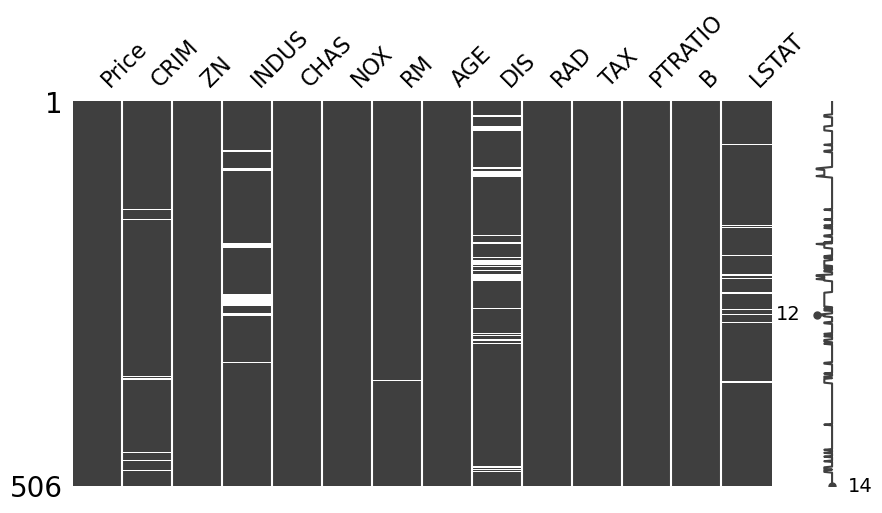

In [131]:
# NaN Check

# Method1 - Use missingno
msno.matrix(df, figsize=(10, 5))

# Method2 - Use isnull method
df.isnull().sum()

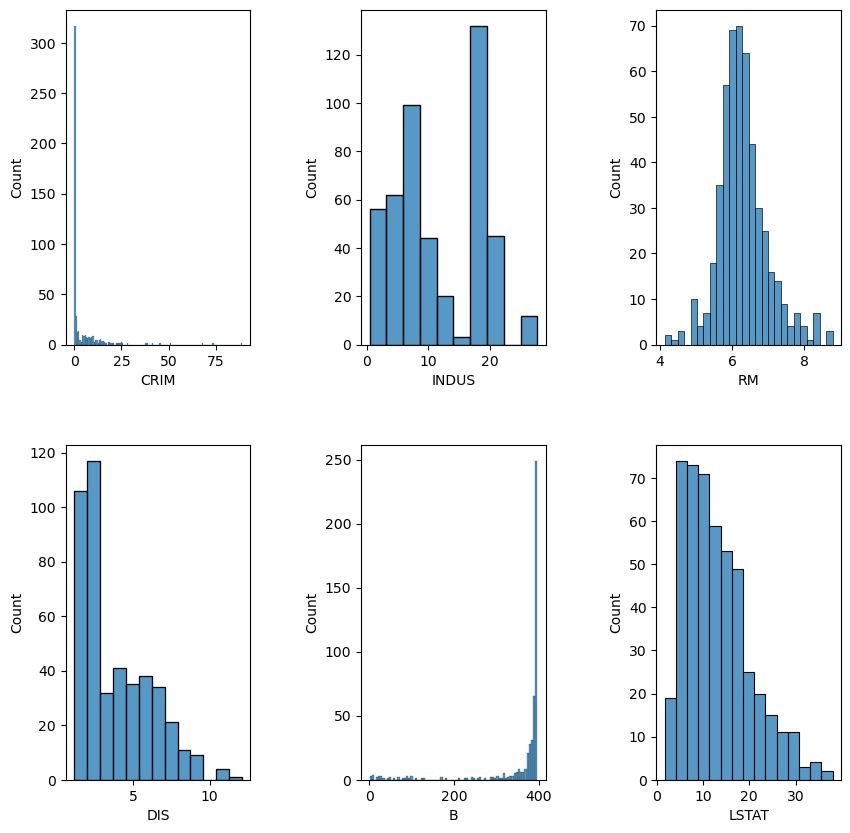

In [132]:
# Check NaN Data Distributions
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
plt.subplots_adjust(wspace=0.6, hspace=0.3)

axs = axs.flatten()

for idx, col in enumerate(df.columns[df.isnull().sum() != 0]):
    sns.histplot(data=df, x=col, ax=axs[idx])


In [133]:
# Nan Data Preprocessing
# Fill Nan Data to Median or Mean Value
 
for col in df.columns[df.isnull().sum() != 0]:
    if col in ['CRIM', 'DIS', 'B']:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)

In [134]:
# Feature Convert

def feature_convert(df_origin):
    df = df_origin.copy()

    interval = [100, 200, 300, 400, 500, 600, 700, 800]
    if df['TAX'].max() >= 100:
        df['TAX'] = np.digitize(df['TAX'], bins=interval)
    
    if 'TAX' in df.columns:
        df_dummy = pd.get_dummies(df['TAX'], prefix='TAX', drop_first=True)
        df = pd.concat([df, df_dummy], axis=1)
        del df['TAX']
     
    df['CHAS'] = df['CHAS'].astype(int)
    
    return df

In [135]:
# Set Variables & Split Data
# X_train, X_test, Y_train, Y_test 4 Group Split
# Dependent/Independent variables Split

def datasplit(df, Y_colname):
    X_colname = [x for x in df.columns if x not in Y_colname]

    X_train, X_test, Y_train, Y_test = train_test_split(df[X_colname], df[Y_colname], 
                                                        test_size=0.2, random_state=123) # Test set ratio: 20%
    
    return X_train, X_test, Y_train, Y_test



Y_colname = ['Price']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

X_train_fc = feature_convert(X_train)
X_test_fc = feature_convert(X_test)
display(X_train_fc, X_test_fc)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,PTRATIO,B,LSTAT,TAX_2,TAX_3,TAX_4,TAX_6,TAX_7
203,0.04,95.00,2.68,0,0.42,7.85,33.20,5.12,4,14.70,392.78,12.97,1,0,0,0,0
441,9.72,0.00,18.10,0,0.74,6.41,97.20,2.07,24,20.20,385.96,19.52,0,0,0,1,0
172,0.14,0.00,4.05,0,0.51,5.57,88.50,2.60,5,16.60,396.90,14.69,1,0,0,0,0
95,0.12,0.00,2.89,0,0.45,6.62,57.80,2.83,2,18.00,357.98,6.65,1,0,0,0,0
54,0.01,75.00,4.00,0,0.41,5.89,47.60,7.32,3,21.10,396.90,14.80,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.08,0.00,2.89,0,0.45,7.82,36.90,2.83,2,18.00,393.53,12.97,1,0,0,0,0
476,4.87,0.00,18.10,0,0.61,6.48,93.60,2.31,24,20.20,396.21,18.68,0,0,0,1,0
322,0.35,0.00,7.38,0,0.49,6.04,49.90,4.72,5,19.60,396.90,7.70,1,0,0,0,0
382,9.19,0.00,18.10,0,0.70,5.54,100.00,1.58,24,20.20,396.90,23.60,0,0,0,1,0


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,PTRATIO,B,LSTAT,TAX_2,TAX_3,TAX_4,TAX_6
410,51.14,0.00,18.10,0,0.60,5.76,100.00,1.41,24,20.20,2.60,10.11,0,0,0,1
85,0.06,0.00,4.49,0,0.45,6.63,56.10,4.44,3,18.50,392.30,6.53,1,0,0,0
280,0.04,20.00,11.66,0,0.44,7.82,64.50,4.69,5,14.90,387.31,12.97,1,0,0,0
422,12.05,0.00,18.10,0,0.61,5.65,87.60,1.95,24,20.20,291.55,14.10,0,0,0,1
199,0.03,95.00,1.47,0,0.40,6.97,15.30,7.65,3,17.00,396.90,4.56,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,0.44,0.00,6.20,0,0.50,6.55,21.40,2.83,8,17.40,380.34,12.97,0,1,0,0
159,1.43,0.00,19.58,0,0.87,6.51,100.00,1.77,5,14.70,364.31,7.39,0,0,1,0
196,0.04,80.00,1.52,0,0.40,7.29,34.10,7.31,2,12.60,396.90,4.08,0,1,0,0
345,0.03,0.00,4.39,0,0.44,6.01,48.50,8.01,3,18.80,385.64,10.53,0,1,0,0


In [136]:
# Synchronize train, test column

def col_mapping(X_train, X_test):
    X_tr = X_train.copy()
    X_te = X_test.copy()

    X_tr_omit_col = [i for i in X_te.columns if i not in X_tr.columns]
    X_te_omit_col = [i for i in X_tr.columns if i not in X_te.columns]

    if X_tr_omit_col is not None:
        for i in X_tr_omit_col:
            X_tr[i] = 0
    
    if X_te_omit_col is not None:
        for i in X_te_omit_col:
            X_te[i] = 0
    
    return X_tr, X_te


X_train_fc, X_test_fc = col_mapping(X_train_fc, X_test_fc)
display(X_train_fc, X_test_fc)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,PTRATIO,B,LSTAT,TAX_2,TAX_3,TAX_4,TAX_6,TAX_7
203,0.04,95.00,2.68,0,0.42,7.85,33.20,5.12,4,14.70,392.78,12.97,1,0,0,0,0
441,9.72,0.00,18.10,0,0.74,6.41,97.20,2.07,24,20.20,385.96,19.52,0,0,0,1,0
172,0.14,0.00,4.05,0,0.51,5.57,88.50,2.60,5,16.60,396.90,14.69,1,0,0,0,0
95,0.12,0.00,2.89,0,0.45,6.62,57.80,2.83,2,18.00,357.98,6.65,1,0,0,0,0
54,0.01,75.00,4.00,0,0.41,5.89,47.60,7.32,3,21.10,396.90,14.80,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.08,0.00,2.89,0,0.45,7.82,36.90,2.83,2,18.00,393.53,12.97,1,0,0,0,0
476,4.87,0.00,18.10,0,0.61,6.48,93.60,2.31,24,20.20,396.21,18.68,0,0,0,1,0
322,0.35,0.00,7.38,0,0.49,6.04,49.90,4.72,5,19.60,396.90,7.70,1,0,0,0,0
382,9.19,0.00,18.10,0,0.70,5.54,100.00,1.58,24,20.20,396.90,23.60,0,0,0,1,0


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,PTRATIO,B,LSTAT,TAX_2,TAX_3,TAX_4,TAX_6,TAX_7
410,51.14,0.00,18.10,0,0.60,5.76,100.00,1.41,24,20.20,2.60,10.11,0,0,0,1,0
85,0.06,0.00,4.49,0,0.45,6.63,56.10,4.44,3,18.50,392.30,6.53,1,0,0,0,0
280,0.04,20.00,11.66,0,0.44,7.82,64.50,4.69,5,14.90,387.31,12.97,1,0,0,0,0
422,12.05,0.00,18.10,0,0.61,5.65,87.60,1.95,24,20.20,291.55,14.10,0,0,0,1,0
199,0.03,95.00,1.47,0,0.40,6.97,15.30,7.65,3,17.00,396.90,4.56,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,0.44,0.00,6.20,0,0.50,6.55,21.40,2.83,8,17.40,380.34,12.97,0,1,0,0,0
159,1.43,0.00,19.58,0,0.87,6.51,100.00,1.77,5,14.70,364.31,7.39,0,0,1,0,0
196,0.04,80.00,1.52,0,0.40,7.29,34.10,7.31,2,12.60,396.90,4.08,0,1,0,0,0
345,0.03,0.00,4.39,0,0.44,6.01,48.50,8.01,3,18.80,385.64,10.53,0,1,0,0,0


In [137]:
# Scaling Data Value

def scale(data):
    scaler = preprocessing.MinMaxScaler()    
    scaler_fit = scaler.fit(data)
    result = scaler_fit.transform(data)
    scale = pd.DataFrame(result, columns=data.columns, index=data.index)

    return scale


X_train_fcs = scale(X_train_fc)
X_test_fcs = scale(X_test_fc)

display(X_train_fcs, X_test_fcs)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,PTRATIO,B,LSTAT,TAX_2,TAX_3,TAX_4,TAX_6,TAX_7
203,0.00,0.95,0.08,0.00,0.06,0.81,0.29,0.36,0.13,0.22,0.99,0.32,1.00,0.00,0.00,0.00,0.00
441,0.11,0.00,0.65,0.00,0.73,0.49,0.97,0.08,1.00,0.81,0.97,0.50,0.00,0.00,0.00,1.00,0.00
172,0.00,0.00,0.13,0.00,0.26,0.31,0.88,0.13,0.17,0.43,1.00,0.37,1.00,0.00,0.00,0.00,0.00
95,0.00,0.00,0.09,0.00,0.12,0.54,0.55,0.15,0.04,0.57,0.90,0.14,1.00,0.00,0.00,0.00,0.00
54,0.00,0.75,0.13,0.00,0.05,0.38,0.44,0.56,0.09,0.90,1.00,0.37,0.00,0.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.00,0.00,0.09,0.00,0.12,0.80,0.33,0.15,0.04,0.57,0.99,0.32,1.00,0.00,0.00,0.00,0.00
476,0.05,0.00,0.65,0.00,0.47,0.51,0.93,0.10,1.00,0.81,1.00,0.48,0.00,0.00,0.00,1.00,0.00
322,0.00,0.00,0.25,0.00,0.22,0.41,0.47,0.32,0.17,0.74,1.00,0.17,1.00,0.00,0.00,0.00,0.00
382,0.10,0.00,0.65,0.00,0.65,0.30,1.00,0.04,1.00,0.81,1.00,0.62,0.00,0.00,0.00,1.00,0.00


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,PTRATIO,B,LSTAT,TAX_2,TAX_3,TAX_4,TAX_6,TAX_7
410,1.00,0.00,0.69,0.00,0.43,0.35,1.00,0.04,1.00,0.88,0.00,0.23,0.00,0.00,0.00,1.00,0.00
85,0.00,0.00,0.13,0.00,0.12,0.54,0.55,0.44,0.09,0.69,0.99,0.13,1.00,0.00,0.00,0.00,0.00
280,0.00,0.21,0.43,0.00,0.11,0.79,0.63,0.47,0.17,0.27,0.98,0.31,1.00,0.00,0.00,0.00,0.00
422,0.24,0.00,0.69,0.00,0.47,0.33,0.87,0.11,1.00,0.88,0.73,0.34,0.00,0.00,0.00,1.00,0.00
199,0.00,1.00,0.01,0.00,0.03,0.61,0.13,0.86,0.09,0.51,1.00,0.07,0.00,0.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,0.01,0.00,0.20,0.00,0.24,0.52,0.19,0.22,0.30,0.56,0.96,0.31,0.00,1.00,0.00,0.00,0.00
159,0.03,0.00,0.75,0.00,1.00,0.51,1.00,0.08,0.17,0.24,0.92,0.15,0.00,0.00,1.00,0.00,0.00
196,0.00,0.84,0.01,0.00,0.03,0.68,0.32,0.82,0.04,0.00,1.00,0.06,0.00,1.00,0.00,0.00,0.00
345,0.00,0.00,0.13,0.00,0.11,0.40,0.47,0.91,0.09,0.72,0.97,0.24,0.00,1.00,0.00,0.00,0.00


In [138]:
## Base Algorithm : Linear regression

# Constant add
X_train_fcs = sm.add_constant(X_train_fcs)
X_test_fcs = sm.add_constant(X_test_fcs)

In [139]:
# Modeling
model_lr = sm.OLS(Y_train, X_train_fcs).fit()
model_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     68.81
Date:                Fri, 24 Feb 2023   Prob (F-statistic):          2.04e-105
Time:                        15:28:01   Log-Likelihood:                -1188.4
No. Observations:                 404   AIC:                             2413.
Df Residuals:                     386   BIC:                             2485.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.4001      2.939      8.303      0.000      18.622      30.178
CRIM          -9.7302      3.089     -3.150      0.002     -15.803      -3.658
ZN             3.8473      1.554      2.476      0.014       0.792       6.902
INDUS         -0.9023      1.891     -0.477      0.634      -4.621       2.817
CHAS           1.3915      1.036      1.343      0.180      -0.646       3.429
NOX           -6.4164      2.139     -2.999      0.003     -10.622      -2.210
RM            28.8257      2.137     13.489      0.000      24.624      33.027
AGE           -3.0406      1.379     -2.205      0.028      -5.752      -0.329
DIS          -13.2021      2.329     -5.668      0.000     -17.781      -8.623
RAD           10.8004      4.248      2.542      0.011       2.448      19.153
PTRATIO       -8.1512      1.387     -5.879      0.000     -10.877      -5.425
B              4.1042      1.230      3.336      0.001       1.686       6.523
LSTAT         -9.9004      2.011     -4.923      0.000     -13.854      -5.947
TAX_2         -5.4491      1.399     -3.894      0.000      -8.200      -2.698
TAX_3         -5.9879      1.455     -4.116      0.000      -8.848      -3.127
TAX_4         -5.2948      1.535     -3.450      0.001      -8.312      -2.277
TAX_6        -13.3092      4.293     -3.100      0.002     -21.750      -4.868
TAX_7         -6.5270      2.661     -2.453      0.015     -11.759      -1.295
==============================================================================
Omnibus:                      246.600   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3328.660
Skew:                           2.339   Prob(JB):                         0.00
Kurtosis:                      16.261   Cond. No.                         50.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [140]:
# Eliminate None Significance Variables
# After Eliminate Variables Model

X_train_fcs = X_train_fcs.drop(['ZN', 'INDUS', 'CHAS', 'AGE', 'RAD'], axis=1)
X_test_fcs = X_test_fcs.drop(['ZN', 'INDUS', 'CHAS', 'AGE', 'RAD'], axis=1)

# Training Model
model_lr_elim = sm.OLS(Y_train, X_train_fcs).fit()

# Trained Model Predictions
Y_train_pred = pd.DataFrame(model_lr_elim.predict(X_train_fcs), columns=['Pred'])
Y_test_pred = pd.DataFrame(model_lr_elim.predict(X_test_fcs), columns=['Pred'])

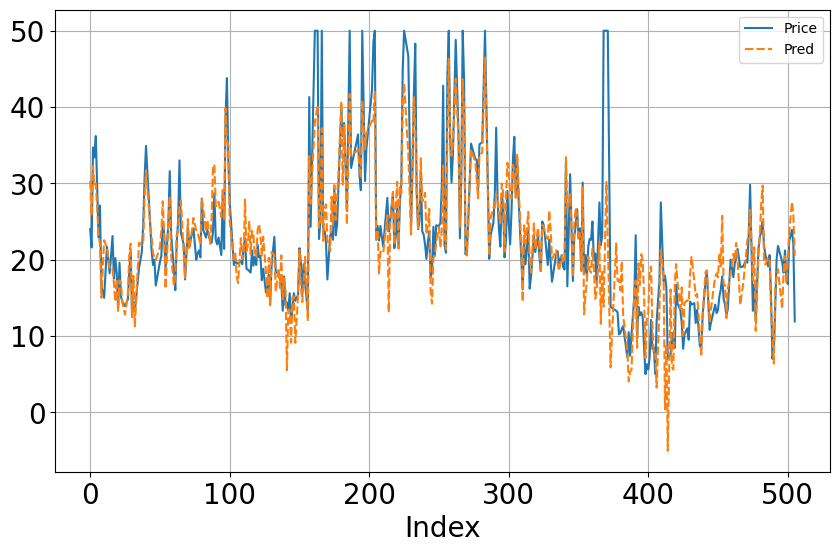

In [141]:
# Model Plotting
def plot_prediction(Y_data, Y_pred):
    comparsion = pd.concat([Y_data, Y_pred], axis=1)
    fig = plt.figure(figsize=(10, 6))
    fig.set_facecolor('white')
    plt.grid()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Index', fontsize=20)
    sns.lineplot(comparsion)


plot_prediction(Y_train, Y_train_pred)

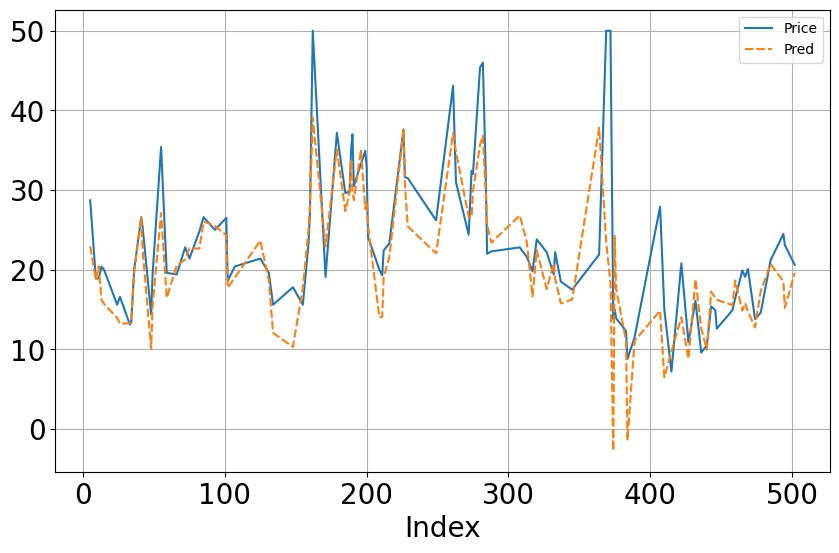

In [142]:
plot_prediction(Y_test, Y_test_pred)

In [144]:
# Evalution

def evaluation_indicators(real, pred):
    MAE = mean_absolute_error(real, pred)
    MSE = mean_squared_error(real, pred)
    MAPE = mean_absolute_percentage_error(real, pred)
    score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['score']).T

    return score


def evaluation_reg(Y_train_real, Y_train_pred, Y_test_real, Y_test_pred):
    train_score = evaluation_indicators(Y_train_real, Y_train_pred)
    test_score = evaluation_indicators(Y_test_real, Y_test_pred)
    total_score = pd.concat([train_score, test_score], axis=0)
    total_score.index = ['Train', 'Test']
    
    return total_score


evaluation_reg(Y_train, Y_train_pred, Y_test, Y_test_pred)

,MAE,MSE,MAPE
Train,3.16,22.10,0.17
Test,4.06,39.55,0.18


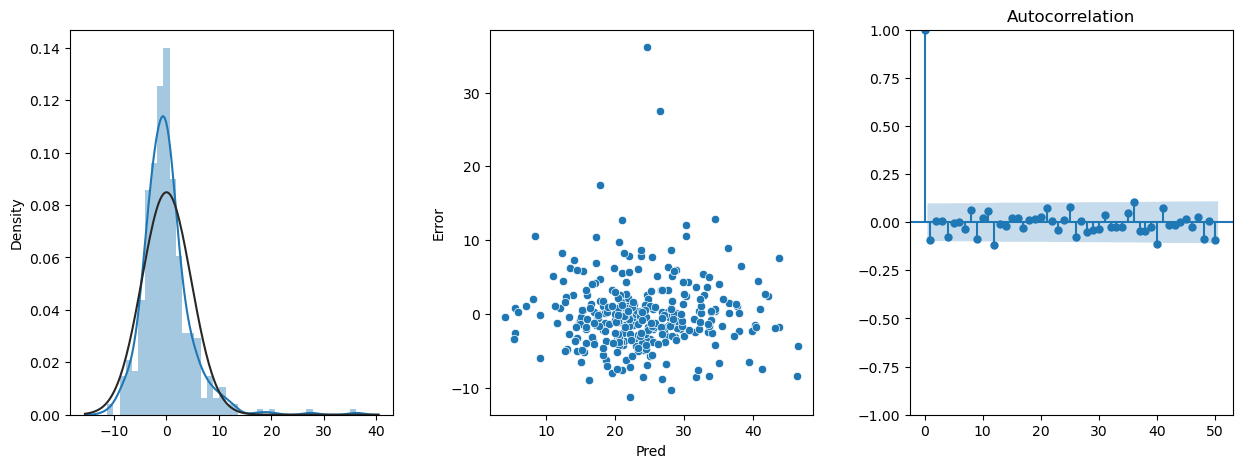

,Normality,Homoscedasticity,Autocorr(lag 10),Autocorr(lag 50)
Statistics,0.87,0.77,11.31,56.18
p-value,0.00,0.07,0.33,0.25
Alternative,NaN,two-sided,NaN,NaN


In [164]:
# Error Analysis

def error_analysis(X_data, Y_data_pred, Y_data_real, graph=False):

    residual = Y_data_real - Y_data_pred.values
    residual.columns = ['Error']
    # Null hypothesis: The residuals are normalized
    normality = pd.DataFrame([stats.shapiro(residual)], 
                             index=['Normality'], columns=['Statistics', 'p-value']).T
    
    # Null hypothesis: Error terms are homoscedastic
    homoscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(residual, X_data.values, alternative='two-sided')], 
                                     index=['Homoscedasticity'],
                                     columns=['Statistics', 'p-value', 'Alternative']).T
    
    # Null hypothesis: Autocorrelation is absent
    autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(residual, lags=[10, 50]).iloc[:, 0]),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(residual, lags=[10, 50]).iloc[:, 1])], axis=1).T
    autocorrelation.index = ['Statistics', 'p-value']
    autocorrelation.columns = ['Autocorr(lag 10)', 'Autocorr(lag 50)']

    error_analysis = pd.concat([normality, homoscedasticity, autocorrelation], join='outer', axis=1)

    # Visualization
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    plt.subplots_adjust(wspace=0.3, hspace=0.6)
    # Check normalization
    sns.distplot(residual, norm_hist='True', fit=stats.norm, ax= axs[0])
    # Check homoscedasticity
    temp = pd.concat([Y_data_pred, residual.reset_index().iloc[:, [1]]], axis=1)
    sns.scatterplot(x='Pred', y='Error', data=temp, ax=axs[1])
    # Check autocorrelation
    sm.graphics.tsa.plot_acf(residual, lags=50, use_vlines=True, ax=axs[2])
    plt.show()

    return error_analysis

error_analysis(X_train_fcs, Y_train_pred, Y_train)